In [21]:
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

In [44]:
# Function to load DICOM images from a folder
def load_dicom_images(folder_path):
    """
    Load DICOM images from a folder.

    Args:
        folder_path (str): Path to the folder containing DICOM images.

    Returns:
        list: List of DICOM images.
    """
    dicom_images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".dcm"):
            dicom_file = os.path.join(folder_path, filename)
            dicom_images.append(pydicom.dcmread(dicom_file))
    return dicom_images

# Get the current working directory
current_directory = os.getcwd()

# Path to PatientA and PatientB folders
patientA_folder = os.path.join(current_directory, "data/PatientA")
patientB_folder = os.path.join(current_directory, "data/PatientB")
 
# Load DICOM images for PatientA and PatientB
patientA_images = load_dicom_images(patientA_folder)
patientB_images = load_dicom_images(patientB_folder)

# Check the number of images loaded
print("Number of images in PatientA:", len(patientA_images))
print("Number of images in PatientB:", len(patientB_images))


Number of images in PatientA: 248
Number of images in PatientB: 220


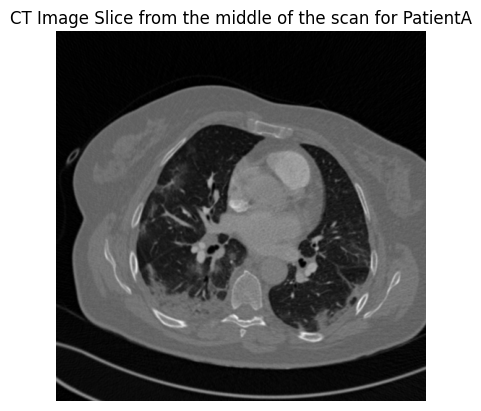

In [41]:

# Display one slice from the middle of the scan
middle_slice_index = len(patientA_images) // 2
plt.imshow(patientA_images[middle_slice_index].pixel_array, cmap='gray')
plt.axis('off')
plt.title('CT Image Slice from the middle of the scan for PatientA')
plt.savefig('middle_slice.png')
plt.show()


In [24]:

# # Function to enhance lung contrast
# def enhance_lung_contrast(image):
#     # Convert image to uint8
#     img_uint8 = (image.pixel_array - np.min(image.pixel_array)) / (np.max(image.pixel_array) - np.min(image.pixel_array)) * 255
#     img_uint8 = img_uint8.astype(np.uint8)
    
#     # Create mask using Otsu's thresholding
#     _, mask = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
#     # Apply histogram equalization only to the lung region
#     lung_region = img_uint8 * (mask / 255)
#     hist, bins = np.histogram(lung_region.flatten(), bins=256, range=(0, 256))
#     cdf = hist.cumsum()
#     cdf = 255 * cdf / cdf[-1]
#     equalized_lung_region = np.interp(lung_region.flatten(), bins[:-1], cdf).reshape(lung_region.shape)
    
#     return equalized_lung_region

# # Apply lung contrast enhancement to the middle slice of PatientA
# enhanced_image = enhance_lung_contrast(patientA_images[middle_slice_index])
# plt.imshow(enhanced_image, cmap='gray')
# plt.axis('off')
# plt.savefig('enhanced_image.png')
# plt.show()

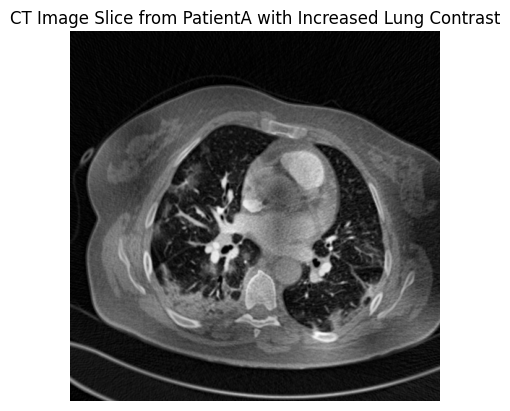

In [42]:
def enhance_lung_contrast(image):
    """
    Enhance lung contrast using adaptive histogram equalization (CLAHE) within the lung region.

    Args:
        image (pydicom.dataset.FileDataset): Input DICOM image.

    Returns:
        np.ndarray: Enhanced image with improved lung contrast.
    """
    # Ensure the input image is in grayscale format
    if len(image.pixel_array.shape) > 2:
        grayscale_image = cv2.cvtColor(image.pixel_array, cv2.COLOR_RGB2GRAY)
    else:
        grayscale_image = image.pixel_array
    
    # Convert image to uint8
    img_uint8 = (grayscale_image - np.min(grayscale_image)) / (np.max(grayscale_image) - np.min(grayscale_image)) * 255
    img_uint8 = img_uint8.astype(np.uint8)
    
    # Apply Otsu's thresholding to segment lung region
    _, binary_mask = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply adaptive histogram equalization (CLAHE) only to the lung region
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_lung_region = clahe.apply(grayscale_image, binary_mask)
    
    return equalized_lung_region

# Apply lung contrast enhancement to the middle slice of PatientA
enhanced_image = enhance_lung_contrast(patientA_images[middle_slice_index])
plt.imshow(enhanced_image, cmap='gray')
plt.title('CT Image Slice from PatientA with Increased Lung Contrast')
plt.axis('off')
plt.savefig('enhanced_image.png')
plt.show()


In [26]:
# Function to calculate statistics on the pixel value range
def calculate_statistics(images):
    """
    Calculate statistics on the pixel value range for a given set of images.

    Args:
        images (list): List of input images (numpy arrays).

    Returns:
        dict: A dictionary containing the statistics (min, max, mean, std) for each image,
              as well as the overall statistics across all images.
    """
    # Initialize empty lists to store statistics
    min_values = []
    max_values = []
    mean_values = []
    std_values = []

    # Calculate statistics for each image
    for image in images:
        min_value = np.min(image.pixel_array)
        max_value = np.max(image.pixel_array)
        mean_value = np.mean(image.pixel_array)
        std_value = np.std(image.pixel_array)
        
        min_values.append(min_value)
        max_values.append(max_value)
        mean_values.append(mean_value)
        std_values.append(std_value)

    # Calculate overall statistics across all images
    overall_min = np.min(min_values)
    overall_max = np.max(max_values)
    overall_mean = np.mean(mean_values)
    overall_std = np.mean(std_values)

    #  Dictionary to store statistics
    statistics = {
        "min": min_values,
        "max": max_values,
        "mean": mean_values,
        "std": std_values,
        "overall_min": overall_min,
        "overall_max": overall_max,
        "overall_mean": overall_mean,
        "overall_std": overall_std
    }

    return statistics

# Calculate statistics for one example image 
example_image_statistics = calculate_statistics([patientA_images[0]])

# Calculate statistics across all images for each patient
patientA_statistics = calculate_statistics(patientA_images)
patientB_statistics = calculate_statistics(patientB_images)

# Combine statistics across both patients
all_patients_statistics = calculate_statistics(patientA_images + patientB_images)

# Print example image statistics
print("Example image statistics:")
print(example_image_statistics)

# Print statistics for each patient
print("\nPatient A statistics:")
print(patientA_statistics)
print("\nPatient B statistics:")
print(patientB_statistics)

# Print statistics for all patients
print("\nAll patients statistics:")
print(all_patients_statistics)

Example image statistics:
{'min': [0], 'max': [4095], 'mean': [513.7883758544922], 'std': [514.2170318285079], 'overall_min': 0, 'overall_max': 4095, 'overall_mean': 513.7883758544922, 'overall_std': 514.2170318285079}

Patient A statistics:
{'min': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'max

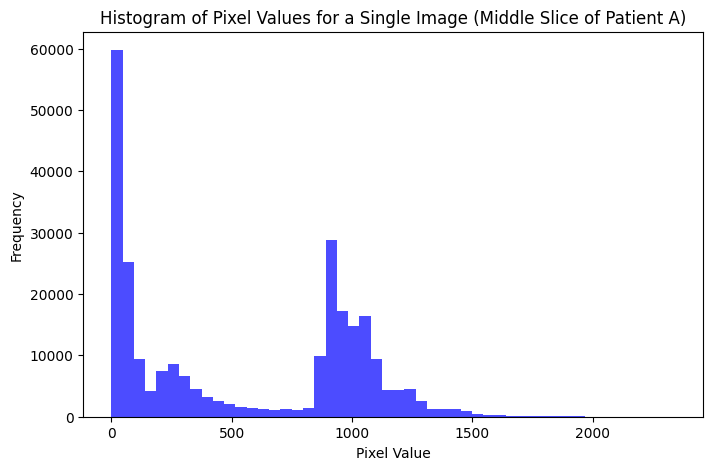

In [27]:
# Plot histogram of pixel values for the middle slice of Patient A
plt.figure(figsize=(8, 5))
plt.hist(patientA_images[middle_slice_index].pixel_array.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Values for a Single Image (Middle Slice of Patient A)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.savefig('Histogram_of_Pixel_Values_for_a_Single_Image')
plt.show()


### Histogram of Pixel Values for a Single Image

**Description:**
The histogram represents the distribution of pixel intensity values in a single image, specifically the middle slice of a CT scan from Patient A.

**Observations:**
- The histogram displays two prominent peaks:
  - A peak near 0 pixel value (dark pixels) with a high frequency.
  - Another peak around 1000 pixel value (brighter pixels) with a lower frequency.
- The distribution indicates the presence of both dark and bright regions within the image.

**Interpretation:**
- The dark peak likely corresponds to background or non-lung regions, such as air or other tissues.
- The brighter peak may represent lung tissue or structures with higher attenuation, such as blood vessels.
- Variations in pixel values provide insights into the contrast and intensity characteristics of the image.

**Significance:**
- Understanding the pixel value distribution helps clinicians assess image quality, identify abnormalities, and optimize visualization for diagnostic purposes.
- In the context of lung imaging, analyzing pixel value distributions aids in the detection and characterization of lung diseases and pathologies.

**Why:** 
- Histogram analysis offers a quantitative understanding of the distribution of pixel intensities within the image.
- By examining pixel value distributions, clinicians can identify regions of interest, assess image quality, and detect anomalies or pathologies based on variations in intensity.
- This information assists in making informed diagnostic and treatment decisions, enhancing the interpretation of medical images for improved patient care.


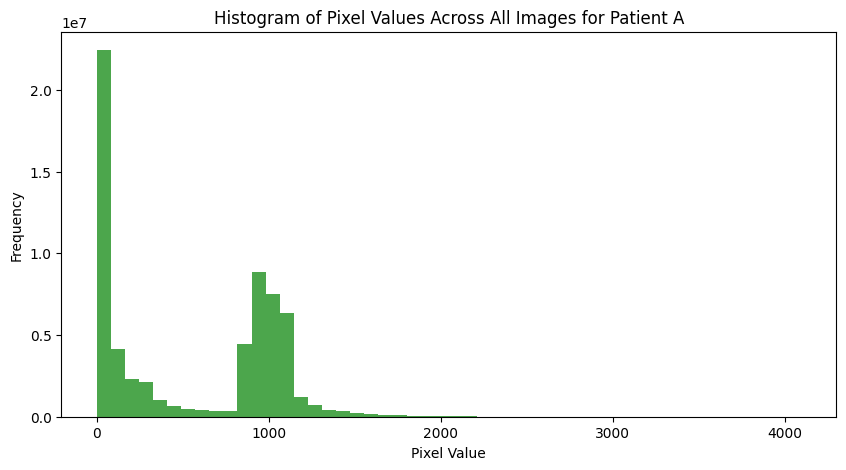

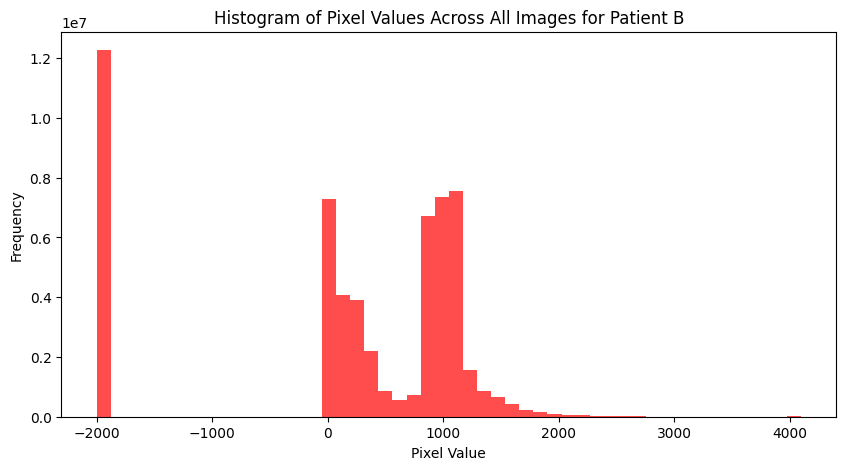

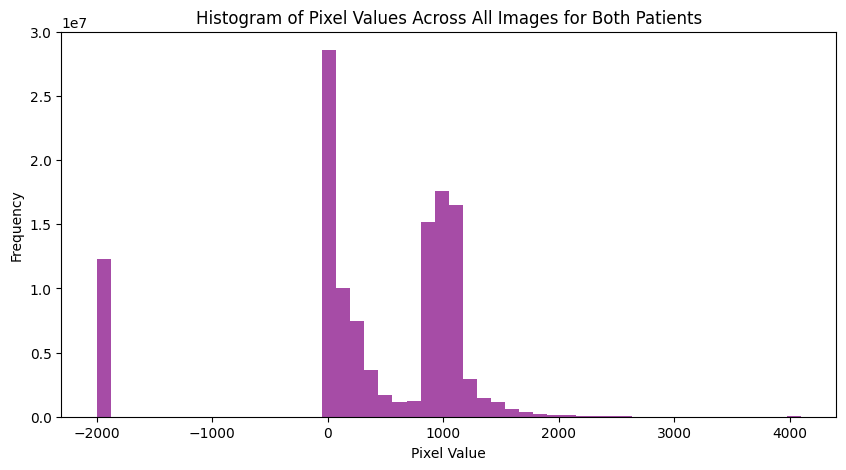

In [28]:
# Plot histogram of pixel values across all images for Patient A
plt.figure(figsize=(10, 5))
plt.hist(np.concatenate([image.pixel_array.flatten() for image in patientA_images]), bins=50, color='green', alpha=0.7)
plt.title('Histogram of Pixel Values Across All Images for Patient A')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.savefig('histogram_patientA.png')
plt.show()

# Plot histogram of pixel values across all images for Patient B
plt.figure(figsize=(10, 5))
plt.hist(np.concatenate([image.pixel_array.flatten() for image in patientB_images]), bins=50, color='red', alpha=0.7)
plt.title('Histogram of Pixel Values Across All Images for Patient B')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.savefig('histogram_patientB.png')
plt.show()

# Plot histogram of pixel values across all images for both patients combined
all_images = patientA_images + patientB_images
plt.figure(figsize=(10, 5))
plt.hist(np.concatenate([image.pixel_array.flatten() for image in all_images]), bins=50, color='purple', alpha=0.7)
plt.title('Histogram of Pixel Values Across All Images for Both Patients')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.savefig('histogram_both_patients.png')
plt.show()


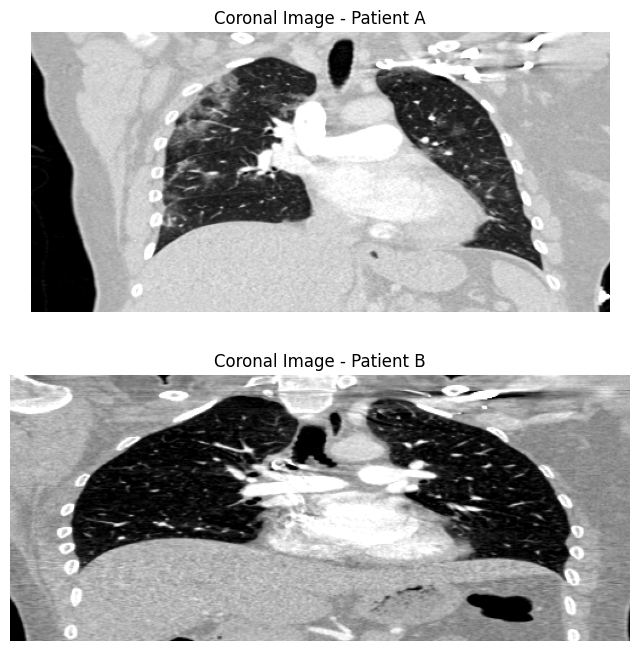

In [29]:

def reconstruct_coronal_image(images):
    """
    Reconstructs a coronal image from a series of axial slices.

    Args:
        images (list): List of DICOM images representing axial slices.

    Returns:
        np.ndarray: Reconstructed coronal image.
    """
    # Stack axial slices along the coronal axis
    coronal_image = np.stack([image.pixel_array for image in images], axis=0)
    # Calculate the middle slice index
    middle_slice_index = coronal_image.shape[1] // 2
    # Select the middle slice along the coronal axis
    middle_coronal_slice = coronal_image[:, middle_slice_index, :]
    return middle_coronal_slice

# Reconstruct coronal image for Patient A
coronal_image_patientA = reconstruct_coronal_image(patientA_images)

# Reconstruct coronal image for Patient B
coronal_image_patientB = reconstruct_coronal_image(patientB_images)

# Adjust dynamic range for better visualization
# Calculate dynamic range based on percentiles to handle extreme values more effectively
# Here, we use the 5th and 95th percentiles as the dynamic range to retain 90% of the pixel values
percentile_min_A = np.percentile(coronal_image_patientA, 5)
percentile_max_A = np.percentile(coronal_image_patientA, 95)
percentile_min_B = np.percentile(coronal_image_patientB, 5)
percentile_max_B = np.percentile(coronal_image_patientB, 95)

# Justification for Dynamic Range:
# - Using percentiles ensures that extreme values are excluded, enhancing contrast and reducing the impact of outliers.
# - By retaining 90% of the pixel values (from the 5th to 95th percentile), we preserve most of the image's information while minimizing the influence of noise or artifacts.

# Adjust dynamic range for both patients
adjusted_coronal_image_patientA = np.clip(coronal_image_patientA, percentile_min_A, percentile_max_A)
adjusted_coronal_image_patientB = np.clip(coronal_image_patientB, percentile_min_B, percentile_max_B)

# Plot and save reconstructed coronal images
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.imshow(adjusted_coronal_image_patientA, cmap='gray')
plt.title('Coronal Image - Patient A')
plt.axis('off')
plt.savefig('coronal_image_patientA.png')

plt.subplot(2, 1, 2)
plt.imshow(adjusted_coronal_image_patientB, cmap='gray')
plt.title('Coronal Image - Patient B')
plt.axis('off')
plt.savefig('coronal_image_patientB.png')

plt.show()


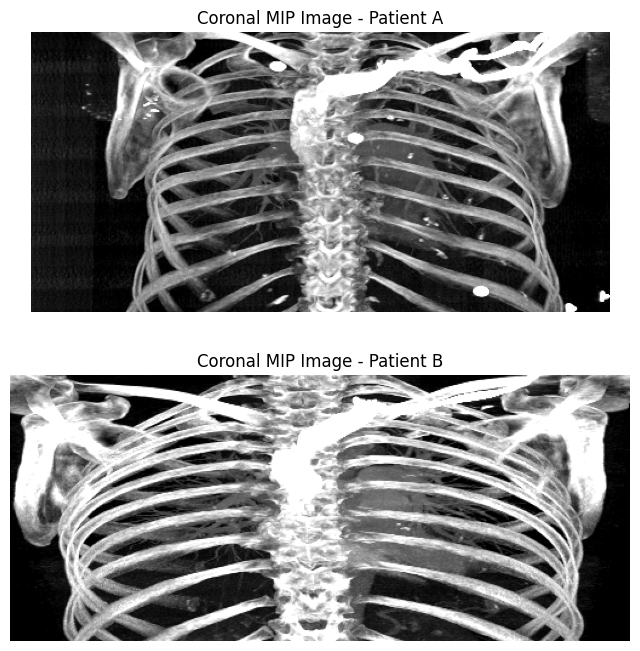

In [30]:
def create_coronal_MIP(images):
    """
    Create a Maximum Intensity Projection (MIP) image in the coronal plane from a series of axial slices.

    Args:
        images (list): List of DICOM images representing axial slices.

    Returns:
        np.ndarray: Coronal MIP image.
    """
    # Stack axial slices along the coronal axis
    coronal_image = np.stack([image.pixel_array for image in images], axis=0)
    # Calculate the MIP along the coronal axis
    coronal_MIP = np.max(coronal_image, axis=1)
    return coronal_MIP

# Create coronal MIP image for Patient A
coronal_MIP_patientA = create_coronal_MIP(patientA_images)

# Create coronal MIP image for Patient B
coronal_MIP_patientB = create_coronal_MIP(patientB_images)

# Calculate dynamic range based on percentiles
percentile_min = np.percentile(coronal_MIP_patientA, 5)
percentile_max = np.percentile(coronal_MIP_patientA, 95)

# Adjust dynamic range for both patients
adjusted_coronal_MIP_patientA = np.clip(coronal_MIP_patientA, percentile_min, percentile_max)
adjusted_coronal_MIP_patientB = np.clip(coronal_MIP_patientB, percentile_min, percentile_max)

# Plot and save reconstructed coronal MIP images
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.imshow(adjusted_coronal_MIP_patientA, cmap='gray')
plt.title('Coronal MIP Image - Patient A')
plt.axis('off')
plt.savefig('coronal_MIP_patientA.png')  # Save the coronal MIP image for Patient A

plt.subplot(2, 1, 2)
plt.imshow(adjusted_coronal_MIP_patientB, cmap='gray')
plt.title('Coronal MIP Image - Patient B')
plt.axis('off')
plt.savefig('coronal_MIP_patientB.png')  # Save the coronal MIP image for Patient B

plt.show()


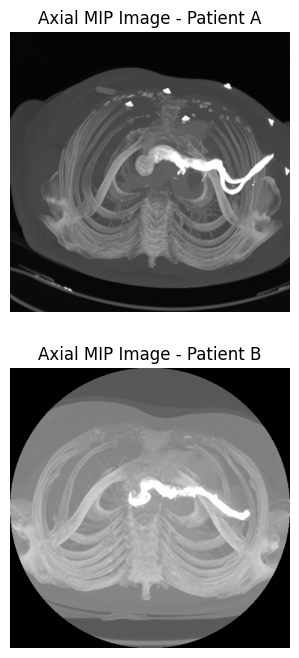

In [40]:
def create_axial_MIP(images):
    """
    Create a Maximum Intensity Projection (MIP) image in the axial plane from a series of axial slices.

    Args:
        images (list): List of DICOM images representing axial slices.

    Returns:
        np.ndarray: Axial MIP image.
    """
    # Stack axial slices along the axial axis (z-axis)
    axial_image = np.stack([image.pixel_array for image in images], axis=0)
    # Calculate the MIP along the axial axis
    axial_MIP = np.max(axial_image, axis=0)
    return axial_MIP

# Create axial MIP image for Patient A
axial_MIP_patientA = create_axial_MIP(patientA_images)

# Create axial MIP image for Patient B
axial_MIP_patientB = create_axial_MIP(patientB_images)

# Plot and save reconstructed axial MIP images
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.imshow(axial_MIP_patientA, cmap='gray')
plt.title('Axial MIP Image - Patient A')
plt.axis('off')
plt.savefig('axial_MIP_patientA.png')  # Save the axial MIP image for Patient A

plt.subplot(2, 1, 2)
plt.imshow(axial_MIP_patientB, cmap='gray')
plt.title('Axial MIP Image - Patient B')
plt.axis('off')
plt.savefig('axial_MIP_patientB.png')  # Save the axial MIP image for Patient B

plt.show()


In [32]:

def calculate_lung_area(images_folder):
    """
    Calculate the lung area (in pixels) for each image cross-section across one patient.

    Args:
        images_folder (str): Path to the folder containing DICOM images.

    Returns:
        list: List containing the lung area (in pixels) for each image cross-section.
    """
    lung_areas = []

    # Iterate through each DICOM image in the folder
    for filename in os.listdir(images_folder):
        if filename.endswith(".dcm"):
            # Read the DICOM image
            dicom_file = os.path.join(images_folder, filename)
            image = pydicom.dcmread(dicom_file).pixel_array

            # Convert to 8-bit unsigned integer
            image = np.uint8(image)

            # Apply Otsu's thresholding method to separate lung tissue from background
            _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Perform morphological closing to fill in any gaps in the binary mask
            kernel = np.ones((5, 5), np.uint8)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            
            # Calculate the lung area by counting non-zero pixels in the binary mask
            lung_area = np.count_nonzero(binary_mask)
            lung_areas.append(lung_area)
    
    return lung_areas


# Calculate lung area for PatientA
lung_areas_patientA = calculate_lung_area(patientA_folder)

# Calculate lung area for PatientB
lung_areas_patientB = calculate_lung_area(patientB_folder)

# Output the lung areas for each image cross-section
for i, area in enumerate(lung_areas_patientA, start=1):
    print(f"Patient A - Image {i}: Lung Area = {area} pixels")

for i, area in enumerate(lung_areas_patientB, start=1):
    print(f"Patient B - Image {i}: Lung Area = {area} pixels")


Patient A - Image 1: Lung Area = 119326 pixels
Patient A - Image 2: Lung Area = 119252 pixels
Patient A - Image 3: Lung Area = 118790 pixels
Patient A - Image 4: Lung Area = 117558 pixels
Patient A - Image 5: Lung Area = 117301 pixels
Patient A - Image 6: Lung Area = 119177 pixels
Patient A - Image 7: Lung Area = 121221 pixels
Patient A - Image 8: Lung Area = 121376 pixels
Patient A - Image 9: Lung Area = 124258 pixels
Patient A - Image 10: Lung Area = 125485 pixels
Patient A - Image 11: Lung Area = 126842 pixels
Patient A - Image 12: Lung Area = 127464 pixels
Patient A - Image 13: Lung Area = 128686 pixels
Patient A - Image 14: Lung Area = 129708 pixels
Patient A - Image 15: Lung Area = 127818 pixels
Patient A - Image 16: Lung Area = 131122 pixels
Patient A - Image 17: Lung Area = 130346 pixels
Patient A - Image 18: Lung Area = 131290 pixels
Patient A - Image 19: Lung Area = 133278 pixels
Patient A - Image 20: Lung Area = 131965 pixels
Patient A - Image 21: Lung Area = 131431 pixels
P

In [33]:
# import numpy as np
# import cv2
# import os

# def threshold_image(image):
#     """
#     Apply thresholding to an input image using Otsu's method.

#     Args:
#         image (numpy.ndarray): Input grayscale image.
#         threshold_value (int): Threshold value for segmentation.

#     Returns:
#         numpy.ndarray: Binary mask of segmented lung regions.
#     """
#     _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     return binary_mask

# def perform_morphological_operations(binary_mask, kernel_size=(5, 5), operation=cv2.MORPH_CLOSE):
#     """
#     Perform morphological operations on a binary mask to refine the lung region segmentation.

#     Args:
#         binary_mask (numpy.ndarray): Binary mask of segmented lung regions.
#         kernel_size (tuple): Size of the kernel for morphological operations. Default is (5, 5).
#         operation (int): Morphological operation to perform. Default is cv2.MORPH_CLOSE.

#     Returns:
#         numpy.ndarray: Refined binary mask after morphological operations.
#     """
#     kernel = np.ones(kernel_size, np.uint8)
#     refined_mask = cv2.morphologyEx(binary_mask, operation, kernel)
#     return refined_mask

# def calculate_lung_area(images_folder):
#     """
#     Calculate the lung area (in pixels) for each image cross-section across one patient.

#     Args:
#         images_folder (str): Path to the folder containing DICOM images.

#     Returns:
#         list: List containing the lung area (in pixels) for each image cross-section.
#     """
#     lung_areas = []

#     # Iterate through each DICOM image in the folder
#     for filename in os.listdir(images_folder):
#         if filename.endswith(".dcm"):
#             # Read the DICOM image
#             dicom_file = os.path.join(images_folder, filename)
#             image = pydicom.dcmread(dicom_file).pixel_array
            
#             # Apply Otsu's thresholding method to separate lung tissue from background
#             binary_mask = threshold_image(image, 0)
            
#             # Perform morphological closing to fill in any gaps in the binary mask
#             refined_mask = perform_morphological_operations(binary_mask)
            
#             # Calculate the lung area by counting non-zero pixels in the binary mask
#             lung_area = np.count_nonzero(refined_mask)
#             lung_areas.append(lung_area)
    
#     return lung_areas

# # Example usage:
# lung_areas_patient = calculate_lung_area(patientA_folder)

# # Output the lung areas for each image cross-section
# for i, area in enumerate(lung_areas_patient, start=1):
#     print(f"Image {i}: Lung Area = {area} pixels")


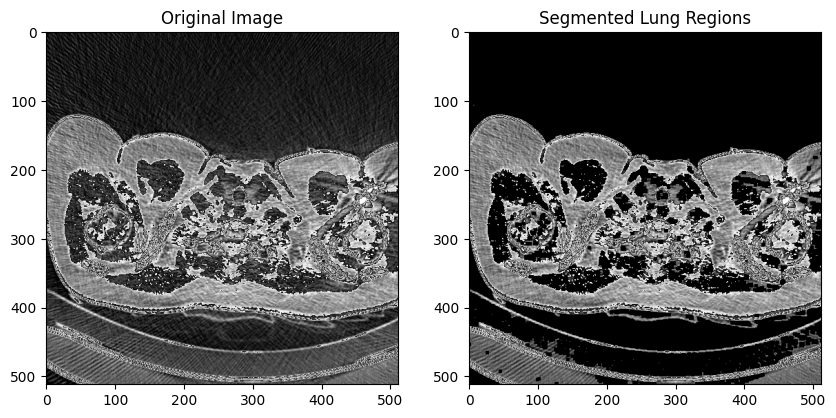

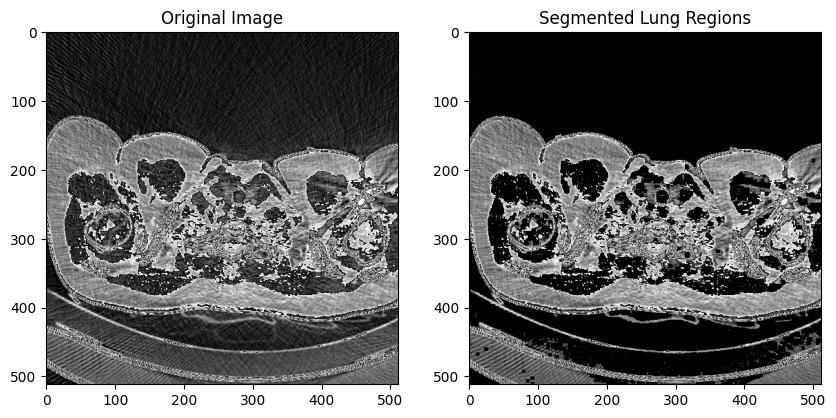

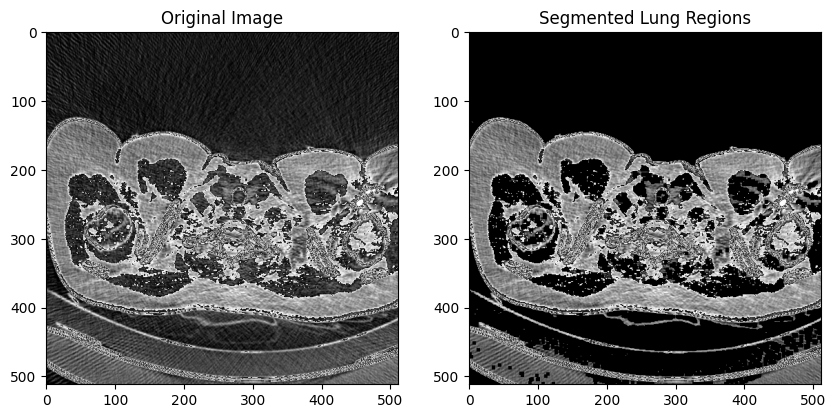

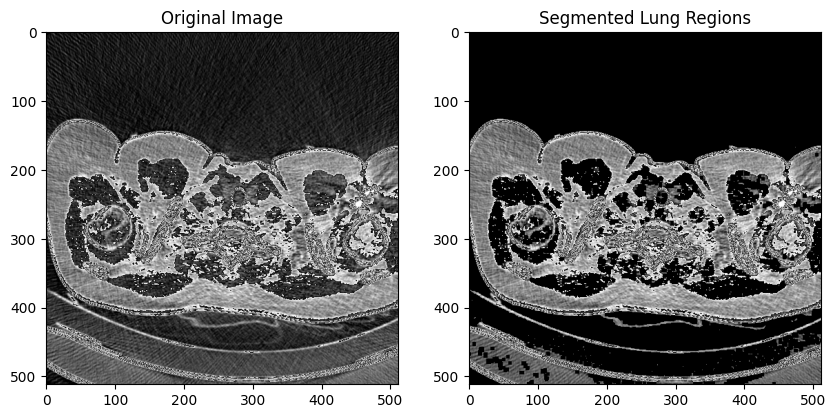

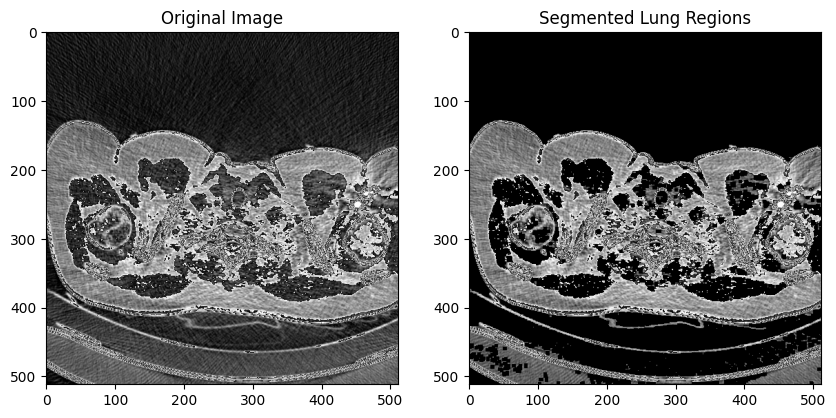

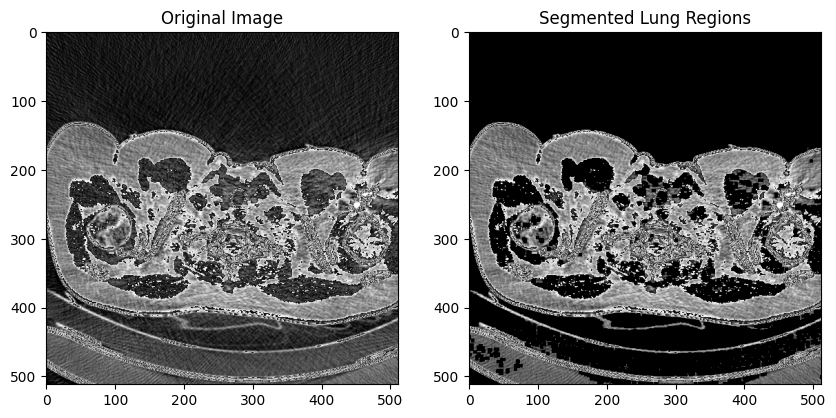

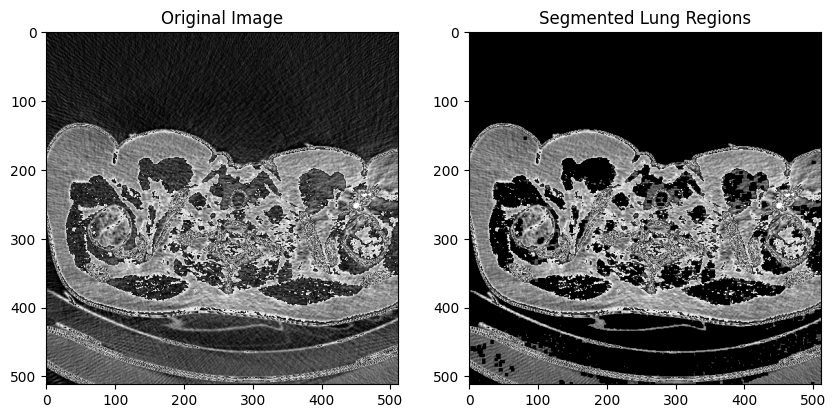

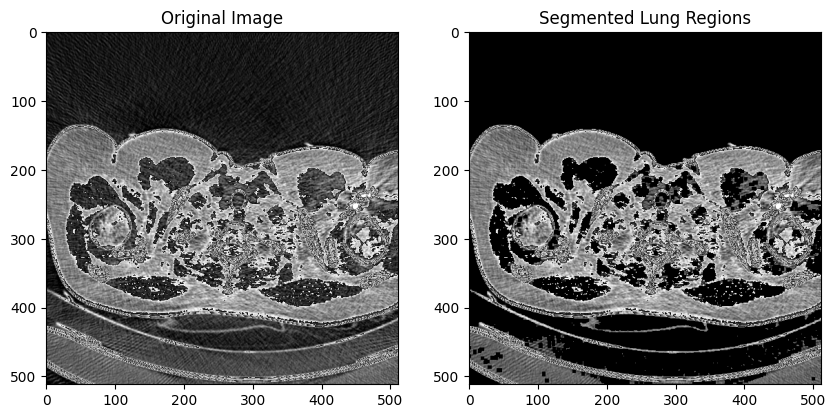

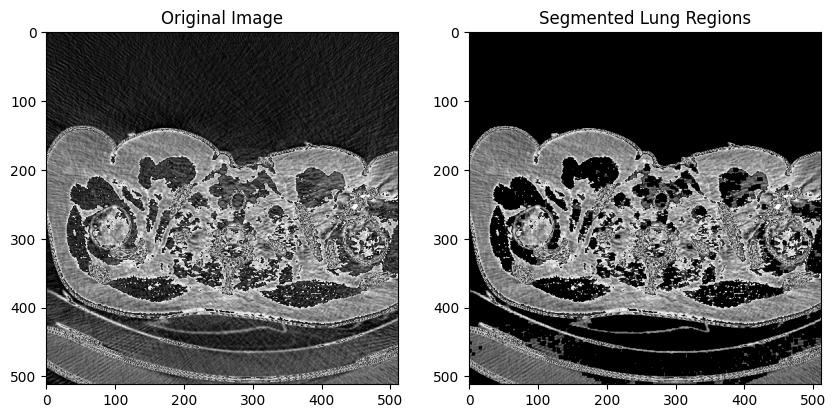

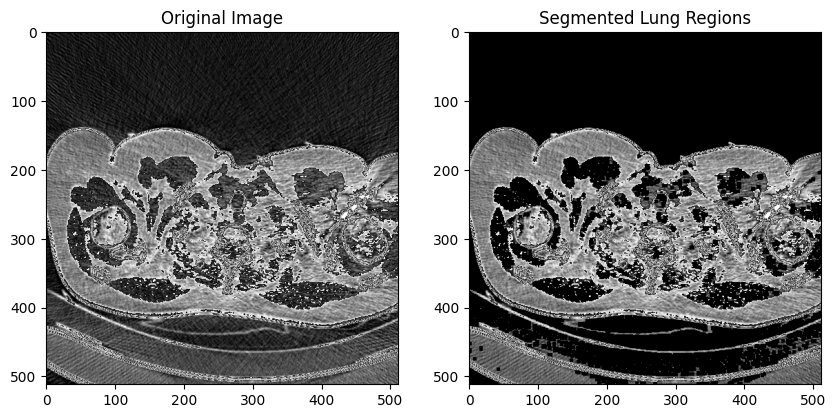

In [34]:
def visualize_segmentation(images_folder, num_images=10):
    """
    Visualize the segmented lung regions overlaid on the original images using stratified sampling we are using visual inspecion to evaluate the program.

    Args:
        images_folder (str): Path to the folder containing DICOM images.
        num_images (int): Number of images to visualize. Defaults to 10.
    """
    # Create a list to store DICOM files for each category (e.g., patient)
    categories = {}
    
    # Iterate through each DICOM image in the folder and categorize them
    for filename in os.listdir(images_folder):
        if filename.endswith(".dcm"):
            patient_id = filename.split("_")[0]  # Extract patient ID from filename
            
            # Add the DICOM file to the corresponding category
            if patient_id not in categories:
                categories[patient_id] = []
            categories[patient_id].append(os.path.join(images_folder, filename))
    
    # Sample images from each category
    sampled_images = []
    remaining_images = num_images  # Keep track of remaining images to sample
    for patient_id, dicom_files in categories.items():
        # Shuffle the DICOM files for each category
        random.shuffle(dicom_files)
        
        # Sample a proportional number of images from each category
        num_samples = min(remaining_images, len(dicom_files))
        sampled_images.extend(dicom_files[:num_samples])
        
        # Update remaining images to sample
        remaining_images -= num_samples
        
        # Check if reached the desired number of images
        if remaining_images == 0:
            break
    
    # Visualize sampled images
    for dicom_file in sampled_images:
        # Read the DICOM image
        image = pydicom.dcmread(dicom_file).pixel_array

        # Convert to 8-bit unsigned integer
        image = np.uint8(image)

        # Apply Otsu's thresholding method to separate lung tissue from background
        _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Perform morphological closing to fill in any gaps in the binary mask
        kernel = np.ones((5, 5), np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # Overlay binary mask on original image
        overlay = cv2.bitwise_and(image, image, mask=binary_mask)

        # Plot original image and segmented lung regions
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(overlay, cmap='gray')
        plt.title('Segmented Lung Regions')
        plt.show()

# Path to DICOM images folder
images_folder = "data/PatientA"

# Visualize segmented lung regions overlaid on original images using stratified sampling for 10 images
visualize_segmentation(images_folder, num_images=10)


In [39]:
def calculate_lung_volume(images_folder):
    """
    Calculate the total lung volume (in pixels) for a patient.

    Args:
        images_folder (str): Path to the folder containing DICOM images for the patient.

    Returns:
        int: Total lung volume (in pixels) for the patient.
    """
    lung_areas = calculate_lung_area(images_folder)
    lung_volume_pixels = sum(lung_areas)
    return lung_volume_pixels

def generate_lung_volume_table(patients_folders):
    """
    Generate a table of lung volume size for each patient.

    Args:
        patients_folders (list): List of paths to folders containing DICOM images for each patient.

    Returns:
        dict: Dictionary containing patient IDs as keys and corresponding lung volumes (in pixels) as values.
    """
    table = {}
    for patient_folder in patients_folders:
        patient_id = os.path.basename(patient_folder)
        try:
            lung_volume = calculate_lung_volume(patient_folder)
            table[patient_id] = lung_volume
        except Exception as e:
            print(f"Error processing {patient_id}: {e}")
    return table

def print_lung_volume_table(table):
    """
    Print the lung volume table.

    Args:
        table (dict): Dictionary containing patient IDs and corresponding lung volumes.

    Returns:
        None
    """
    print("Patient ID\tLung Volume (pixels)")
    for patient_id, lung_volume in table.items():
        print(f"{patient_id}\t\t{lung_volume}")

# Define paths to patient folders
patients_folders = ["data/PatientA", "data/PatientB"]

# Generate lung volume table for each patient
lung_volume_table = generate_lung_volume_table(patients_folders)

# Print lung volume table
print("\nLung Volume Table:")
print_lung_volume_table(lung_volume_table)



Lung Volume Table:
Patient ID	Lung Volume (pixels)
PatientA		36520496
PatientB		34195161


In [36]:
import pydicom
import os

def get_voxel_dimensions(dicom_file):
    """
    Get the voxel dimensions (pixel spacing and slice thickness) from a DICOM file.

    Args:
        dicom_file (str): Path to the DICOM file.

    Returns:
        tuple: A tuple containing the pixel spacing (in mm) and slice thickness (in mm).
    """
    # Read the DICOM file
    ds = pydicom.dcmread(dicom_file)

    # Extract pixel spacing (in mm) from DICOM metadata
    pixel_spacing = ds.PixelSpacing

    # Extract slice thickness (in mm) from DICOM metadata
    slice_thickness = ds.SliceThickness

    return pixel_spacing, slice_thickness

def get_voxel_dimensions_from_folder(folder_path):
    """
    Get the voxel dimensions (pixel spacing and slice thickness) from all DICOM files in a folder.

    Args:
        folder_path (str): Path to the folder containing DICOM files.

    Returns:
        list: A list of tuples containing the pixel spacing and slice thickness for each DICOM file.
    """
    voxel_dimensions_list = []

    # Iterate through each DICOM file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".dcm"):
            dicom_file = os.path.join(folder_path, filename)
            voxel_dimensions = get_voxel_dimensions(dicom_file)
            voxel_dimensions_list.append(voxel_dimensions)
    
    return voxel_dimensions_list

# Example usage:
# Path to the DICOM folder
dicom_folder_path = "data/PatientA"

# Get voxel dimensions from all DICOM files in the folder
all_voxel_dimensions = get_voxel_dimensions_from_folder(dicom_folder_path)

# Print voxel dimensions for each DICOM file
for i, voxel_dimensions in enumerate(all_voxel_dimensions, start=1):
    pixel_spacing, slice_thickness = voxel_dimensions
    print(f"DICOM File {i}: Pixel Spacing (in mm): {pixel_spacing}, Slice Thickness (in mm): {slice_thickness}")


DICOM File 1: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 2: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 3: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 4: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 5: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 6: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 7: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 8: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 9: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 10: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 11: Pixel Spacing (in mm): [0.640625, 0.640625], Slice Thickness (in mm): 1
DICOM File 12: Pixel Spacing (in mm): [0.640625, 0.6